In [33]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
import nltk
from nltk.tokenize import word_tokenize
pd.set_option('display.max_colwidth', None)


In [2]:
%pip install kaggle --quiet

In [3]:
%pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path = '/content/drive/MyDrive/ColabNotebooks/credential/kaggle.json'

!mkdir ~/.kaggle
!cp {path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d eeshawn/flickr30k

100% 4.08G/4.08G [03:34<00:00, 23.3MB/s]
100% 4.08G/4.08G [03:34<00:00, 20.4MB/s]


In [6]:
# !kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

In [7]:
import zipfile
zip_file = "flickr30k.zip"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('dataset')
print('Unzipped the dataset.')
drive.flush_and_unmount()
print('Google Drive unmounted.')


Unzipped the dataset.
Google Drive unmounted.


In [8]:
caption_file_path = '/content/dataset/captions.txt'

with open(caption_file_path, 'r') as file:
    lines = file.readlines()

data = []

for line in lines:
    image_name, caption = line.split(',', 1)
    data.append({'image': image_name.strip(), 'caption': caption.strip()})

df = pd.DataFrame(data)
df = df.drop(0).reset_index(drop=True)

drive.flush_and_unmount()
print('Google Drive unmounted.')

Drive not mounted, so nothing to flush and unmount.
Google Drive unmounted.


In [9]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [10]:
# 영어 문자열 아니면 제거
# <start>, <end 추가>

df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [11]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x: len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

74


In [12]:
df.drop(['seq_len'], axis=1, inplace=True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

create vocab and mapping of token to ID

In [13]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [14]:
print(len(word_dict))
print(word_dict[:5])

17724
['<pad>', '<start>', '<end>', 'in', 'the']


In [15]:
vocab_size = len(word_dict)
print(vocab_size)

17724


In [16]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

17724 17724


In [17]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [18]:
df.head()

,image,caption,cleaned_caption,text_seq
0,1000092795.jpg,"0,Two young guys with shaggy hair look at their hands while hanging out in the yard .","[<start>, young, guys, with, shaggy, hair, look, at, their, hands, while, hanging, out, in, the, yard, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 20, 324, 10, 2069, 104, 177, 14, 60, 148, 21, 313, 69, 3, 4, 479, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000092795.jpg,"1,Two young White males are outside near many bushes .","[<start>, young, white, males, are, outside, near, many, bushes, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 20, 17, 697, 12, 50, 78, 308, 1395, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,1000092795.jpg,"2,Two men in green shirts are standing in a yard .","[<start>, men, in, green, shirts, are, standing, in, yard, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 31, 3, 43, 244, 12, 29, 3, 479, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,1000092795.jpg,"3,A man in a blue shirt standing in a garden .","[<start>, man, in, blue, shirt, standing, in, garden, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 8, 3, 23, 18, 29, 3, 693, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,1000092795.jpg,"4,Two friends enjoy time spent together .","[<start>, friends, enjoy, time, spent, together, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 499, 792, 580, 9584, 131, 2, 0, 0, 0, 0

In [19]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [20]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

143023 28605
15892 3179


In [21]:
len(train)/len(df)*100   # 89 : 11

89.99968536639084

In [22]:
train_samples = len(train)
print(train_samples)

143023


In [23]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

28605 3179


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [25]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data
        self.scalar = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '/content/dataset/flickr30k_images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scalar(img)))

        return image_name, t_img

In [26]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [27]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [28]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [29]:
resnet18._modules.keys()

odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [30]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

- 1: 배치 크기 (batch size)입니다. 여러 이미지를 한 번에 처리하는 일반적인 딥러닝 모델에서는 배치 크기가 1 이상일 수 있습니다. 하지만 여기서는 단일 이미지를 처리하므로 배치 크기가 1입니다.
- 512: 채널의 수입니다. Layer 4의 각 위치에 대해 512개의 특징 맵이 생성됩니다.
- 7, 7: 각 특징 맵의 높이 및 너비입니다. ResNet18의 Layer 4는 입력 이미지를 7x7 그리드로 변환합니다.


In [31]:
# ResNet-18 모델의 마지막 레이어인 layer4의 출력을 가져와서 my_embedding에 저장

def get_vector(t_img):

    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)   # ResNet18의 Layer 4에서 나오는 출력을 저장하기 위한 변수
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

In [32]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/28605 [00:00<?, ?it/s]

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
!cp "/content/drive/MyDrive/Colab Notebooks/file/EncodedImageValidResNet.pkl" .
drive.flush_and_unmount()
print('Google Drive unmounted.')

Google Drive unmounted.


In [36]:
a_file = open("EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [37]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/3179 [00:00<?, ?it/s]

In [38]:
a_file = open("EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [39]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [40]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [41]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

position embedding

In [42]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]

        x = x + self.pe
        return self.dropout(x)

Transformer Decoder

In [43]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0, 1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(
                                                            decoder_input_mask == 0, float('-inf')
                                                            ).masked_fill(
                                                                decoder_input_mask == 1, float(0.0))
        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)


        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)

        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)


        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)

        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask



train

In [44]:
EPOCH = 30

In [45]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')

<ipython-input-45-d3a928c6521d>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  min_val_loss = np.float('Inf')


In [46]:
df.columns

Index(['image', 'caption', 'cleaned_caption', 'text_seq'], dtype='object')

In [47]:
train_loss = []
val_loss = []

In [48]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)


    total_epoch_train_loss = total_epoch_train_loss/total_train_words


    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words

    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )

    train_loss.append(total_epoch_train_loss.item())
    val_loss.append(total_epoch_valid_loss.item())


    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss


    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch ->  0  Training Loss ->  4.906554698944092 Eval Loss ->  4.599305629730225
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.08948278427124 Eval Loss ->  4.2944016456604
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.835665702819824 Eval Loss ->  4.114808559417725
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.66910719871521 Eval Loss ->  3.995051145553589
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.5451486110687256 Eval Loss ->  3.9086413383483887
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.4465904235839844 Eval Loss ->  3.843780994415283
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.3634774684906006 Eval Loss ->  3.786306381225586
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.291823387145996 Eval Loss ->  3.7415850162506104
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.2278213500976562 Eval Loss ->  3.7073862552642822
Writing Model at epoch  8
Epoch ->  9  Training Loss ->  3.1

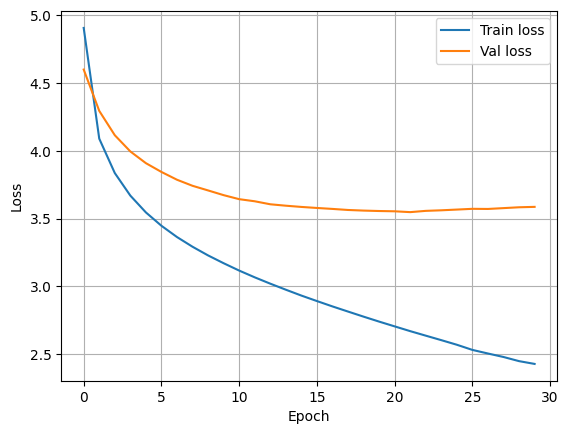

In [49]:
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [50]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 32
print(start_token, end_token, pad_token)

1 2 0


In [51]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [52]:
def generate_caption(K, img_nm):
    img_loc = '/content/dataset/flickr30k_images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval()
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['0,Two men  one wearing a gray shirt and the other wearing a plaid coat  are fishing on a pier .', '1,Two men sit on top of a weathered fort-like structure next to the sea  fishing .', '2,Two men near a lake with fishing poles out into the lake .', '3,Men fishing off of a pier built out of stone .', '4,Two men fish off of a cliff .']


Predicted caption : 
men are on top of rock formation .


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


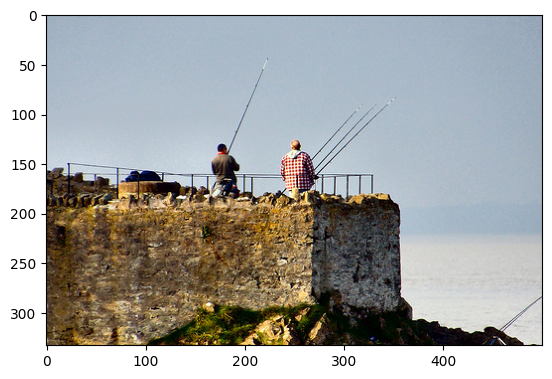

In [53]:
generate_caption(1, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['0,Two men  one wearing a gray shirt and the other wearing a plaid coat  are fishing on a pier .', '1,Two men sit on top of a weathered fort-like structure next to the sea  fishing .', '2,Two men near a lake with fishing poles out into the lake .', '3,Men fishing off of a pier built out of stone .', '4,Two men fish off of a cliff .']


Predicted caption : 
men on the side of road are in the distance on cloudy day .


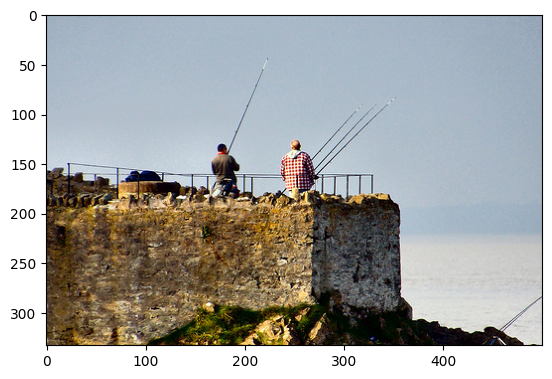

In [54]:
generate_caption(2, unq_valid_imgs.iloc[50]['image'])

Actual Caption : 
['4,A woman with a red shirt and goggles on operates an orange drill .', '3,The woman is using the orange and black cordless drill on the wall .', '0,A woman wearing a pair of glasses with her hair pulled up into a bun is using a power drill and inserting into a wall .', '1,A woman in a red shirt and safety glasses drilling into tile with an orange cordless power drill', '2,A woman wearing safety goggles and a red shirt  using a power drill on tile .']


Predicted caption : 
young man in white and black shirt is sitting in chair .


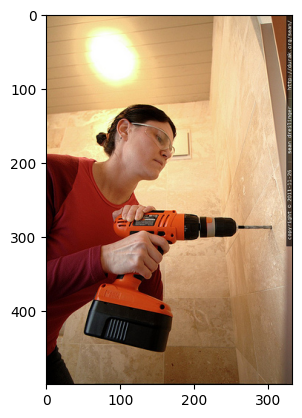

In [55]:
generate_caption(2, unq_valid_imgs.iloc[100]['image'])

In [56]:
%pip install rouge

In [57]:
valid.head(1)

,image,caption,cleaned_caption,text_seq
143023,6337872636.jpg,"3,A group of women sing together while wearing matching black dresses .","[<start>, group, of, women, sing, together, while, wearing, matching, black, dresses, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 36, 9, 49, 1420, 131, 21, 15, 848, 19, 531, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [58]:
unq_valid_imgs.head(1)

,image
143023,6337872636.jpg


In [59]:
test_captions = {}
for idx, row in valid.iterrows():
    image_id = row['image']
    caption = row['caption']

    if image_id not in test_captions:
        test_captions[image_id] = []
    test_captions[image_id].append(caption)

In [60]:
# bleu
# Most common text evaliuation methods
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

In [61]:
unq_valid_imgs.head(1)

,image
143023,6337872636.jpg


In [62]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [63]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from nltk.translate.bleu_score import SmoothingFunction

seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


def calculate_bleu(references, candidate):
    # BLEU 스코어 계산

    smoothing = SmoothingFunction().method1
    bleu_score = sentence_bleu(references, candidate, smoothing_function=smoothing)
    return bleu_score

def calculate_rouge(references, candidate):
    rouge = Rouge()

    references = references[0]
    candidate = " ".join(candidate)

    scores = rouge.get_scores(candidate, references)

    # ROUGE-1 F1 점수의 평균 계산
    rouge_scores = [score['rouge-1']['f'] for score in scores]
    avg_rouge = np.mean(rouge_scores)

    return avg_rouge

def calculate_meteor(references, candidate):
    # references와 candidate를 토큰화
    references_tokenized = [word_tokenize(ref) for ref in references]
    candidate_tokenized = word_tokenize(candidate)

    # METEOR 스코어 계산
    meteor_score_value = meteor_score(references_tokenized, candidate_tokenized)
    return meteor_score_value

# k가 1~5일 떄 bleu, rouge, meteor score 각각 계산하고 어떤 k에서 점수 각각 높은지 저장

def scores(target):

    img_col = []
    k_col = []
    bleu_col = []
    rouge_col = []
    meteor_col = []

    model.eval()
    for idx, row in tqdm(target.iterrows(), total=len(target)):
        img_nm = row['image']

        valid_img_df = valid[valid['image']==img_nm]

        img_embed = valid_img_embed[img_nm].to(device)


        img_embed = img_embed.permute(0,2,3,1)
        img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


        input_seq = [pad_token]*max_seq_len
        input_seq[0] = start_token

        input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)

        for K in range(1, 6):
            predicted_sentence = []
            with torch.no_grad():
                for eval_iter in range(0, max_seq_len): # max_seq_len: 생성하는 시퀀스 최대 길이

                    # 순방향 전파
                    # model.forward(이미지 추출 특성, 현재까지 생성한 시퀀스)
                    output, padding_mask = model.forward(img_embed, input_seq)

                    output = output[eval_iter, 0, :]  # 다음 예측값

                    # 상위 K개 확률값과 해당하는 인덱스 얻기
                    topk_result = torch.topk(output, K)
                    values = topk_result.values.tolist()  # 상위 K개 확률값
                    indices = topk_result.indices.tolist()  # 상위 K개 확률값에 해당하는 인덱스 (모델 어휘 사전에서 각 단어)

                    # Debugging: Check if there are any infinite or NaN values in weights
                    invalid_indices = [i for i, value in enumerate(values) if not np.isfinite(value)]

                    # 무한대 또는 NaN 값을 갖는 원소를 삭제
                    values = [value for i, value in enumerate(values) if i not in invalid_indices]
                    indices = [index for i, index in enumerate(indices) if i not in invalid_indices]

                    # weights가 비어 있는지 확인하고, 비어 있으면 임의로 샘플링
                    if not values:
                        values = [1.0 / K] * K
                        indices = random.choices(range(len(output)), k=K)


                    next_word_index = random.choices(indices, values, k = 1)[0]

                    next_word = index_to_word[next_word_index]

                    # 수정: eval_iter+1이 max_seq_len을 초과할 경우 max_seq_len-1로 고정
                    next_word_index_clipped = min(next_word_index, max_seq_len-1)
                    input_seq[:, next_word_index_clipped] = next_word_index


                    if next_word == '<end>' :
                        break

                    predicted_sentence.append(next_word)

            # 생성된 캡션
            generated_caption = " ".join(predicted_sentence + ['.'])

            # BLEU 스코어 계산을 위해 실제 캡션 가져오기
            actual_captions = valid_img_df['caption'].tolist()

            bleu_score = calculate_bleu(actual_captions, generated_caption)
            rouge_score = calculate_rouge(actual_captions, generated_caption)
            meteor_score = calculate_meteor(actual_captions, generated_caption)

            img_col.append(img_nm)
            k_col.append(K)
            bleu_col.append(bleu_score)
            rouge_col.append(rouge_score)
            meteor_col.append(meteor_score)


    df = pd.DataFrame({
        'image': img_col,
        'K': k_col,
        'bleu': bleu_col,
        'rouge': rouge_col,
        'meteor': meteor_col
    })

    return df


In [64]:
%%time
df2 = scores(unq_valid_imgs)

  0%|          | 0/3179 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


CPU times: user 3h 16min 30s, sys: 8.68 s, total: 3h 16min 39s
Wall time: 50min 5s


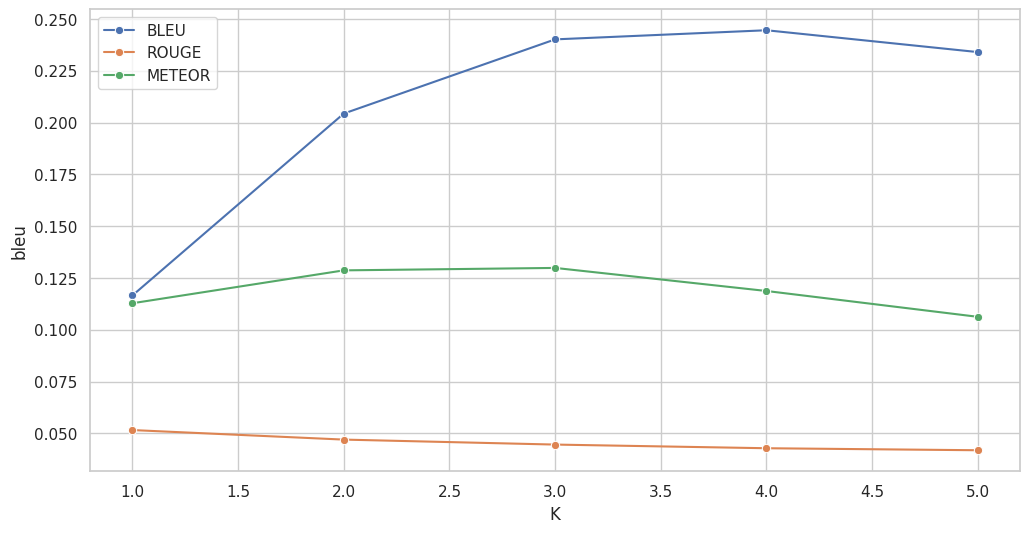

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# 그래프 그리기
sns.set(style="whitegrid")

# Bleu 그래프
plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='bleu', data=df2, marker='o', label='BLEU', errorbar=None)

# Rouge 그래프
#plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='rouge', data=df2, marker='o', label='ROUGE',  errorbar=None)

# Meteor 그래프
#plt.figure(figsize=(12, 6))
sns.lineplot(x='K', y='meteor', data=df2, marker='o', label='METEOR', errorbar=None)

plt.show()

In [66]:
df2.pivot_table(index='K', values=['bleu', 'rouge', 'meteor'], aggfunc='mean')

,bleu,meteor,rouge
K,,,
1,0.116533,0.112790,0.051587
2,0.204324,0.128656,0.046986
3,0.240134,0.129835,0.044582
4,0.244536,0.118703,0.042816
5,0.233998,0.106235,0.041844
